# Ironhack AI Engineering Project

### Importing libraries

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

### Loading dataset

In [30]:
# Load CIFAR-10 dataset.
# We are naming the test part as holdout for now so that we can later split it into validation and test data.
(x_train, y_train), (x_temp, y_temp) = cifar10.load_data()

In [31]:
print(x_train.shape[0], "train samples")
print(y_train.shape[0], "train labels")
print(x_temp.shape[0], "test samples")
print(y_temp.shape[0], "test labels")

50000 train samples
50000 train labels
10000 test samples
10000 test labels


### Split dataset

In [32]:
#Holding out data for test validation, ensuring a consistent split across classes with stratify
# We are getting 50% of the holdout data (test_size=0.50), which was already 20% of the entire dataset.

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(x_test.shape[0], "val samples")
print(y_test.shape[0], "val labels")
print(x_val.shape[0], "test samples")
print(y_val.shape[0], "test labels")


5000 val samples
5000 val labels
5000 test samples
5000 test labels


**Visualising our data**

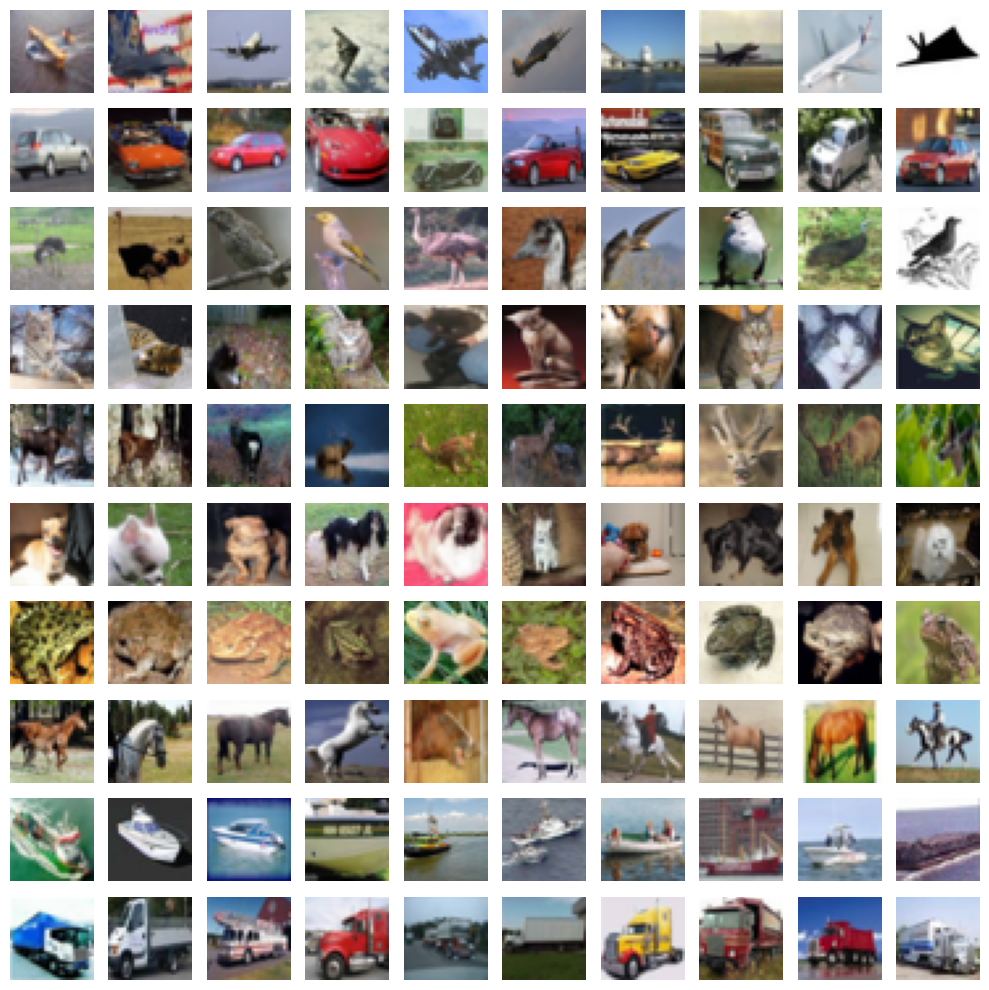

In [34]:
#Visualize: 10×10 grid, 10 random samples per class to make sure we have all classes represented
class_names = ["airplane","automobile","bird","cat","deer",
        "dog","frog","horse","ship","truck"]
y_val_f = y_val.flatten()
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for cls in range(10):
  idxs = np.where(y_val_f == cls)[0]
  sel = np.random.choice(idxs, 10, replace=False)
  for j, idx in enumerate(sel):
    ax = axes[cls, j]
    ax.imshow(x_val[idx].astype("uint8"))
    ax.axis("off")
    # Add class name only to the first column of each row
    if j == 0:
      ax.set_ylabel(class_names[cls], rotation=0, size=10, labelpad=40)
plt.tight_layout()
plt.show()

### Preprocessing data

* Scaling images to the [0,1] range (from [0, 255])
* Converting y into categories with one hot encoding

In [35]:
# Model / data parameters
num_classes = 10
input_shape = (32, 32, 3)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_val = x_val.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [36]:
# convert classes into categories

y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat  = to_categorical(y_test,  num_classes)

## Model Definition

**-----MODEL 17-----**

After a few iterations, this is the winning model.


In [7]:
##block of code used to clear keras sessions during development

#from keras.backend import clear_session
#clear_session()

In [37]:
#we tried Data Augmentation but it didn't improve accuracy and increased running times a lot

#data_augmentation = tf.keras.Sequential([
#    tf.keras.layers.RandomFlip('horizontal'),
#    tf.keras.layers.RandomRotation(0.2),
#])

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        #data_augmentation,  # <--- first layer (only active during training)
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3), #adding dropout rate
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3), #adding dropout rate
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3), #adding dropout rate
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,290 (426.91 KB)

 Trainable params: 108,778 (424.91 KB)

 Non-trainable params: 512 (2.00 KB)

## Model Training

In [38]:
opt = tf.keras.optimizers.Adam()

model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=["accuracy"])

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6),
    LearningRateScheduler(lambda epoch: 1e-3 * 10**(-epoch / 20))
]

history = model.fit(
    x_train, y_train_cat,
    validation_data=(x_val, y_val_cat),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.3331 - loss: 2.0092 - val_accuracy: 0.4516 - val_loss: 1.5327 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5571 - loss: 1.2434 - val_accuracy: 0.6004 - val_loss: 1.1290 - learning_rate: 8.9125e-04
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6409 - loss: 1.0162 - val_accuracy: 0.6924 - val_loss: 0.8767 - learning_rate: 7.9433e-04
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6784 - loss: 0.9085 - val_accuracy: 0.6584 - val_loss: 0.9618 - learning_rate: 7.0795e-04
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7053 - loss: 0.8359 - val_accuracy: 0.6950 - val_loss: 0.8416 - learning_rate: 6.3096e-04
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7221 - loss: 0.7900 - val_accuracy: 0.7530 - val_loss: 0.7210 - learning_rate: 5.6234e-04
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.

## Model evaluation

In [39]:
# Evaluation with training dataset
score_train = model.evaluate(x_train, y_train_cat, verbose=0)
print("Train loss:", score_train[0])
print("Train accuracy:", score_train[1])

# Making predictions with evaluation dataset
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)

# Evaluation with validation dataset
score_val = model.evaluate(x_val, y_val_cat, verbose=0)
print("Validation loss:", score_val[0])
print("Validation accuracy:", score_val[1])

# Making predictions with real unused dataset
predictions_real = model.predict(x_test)
predictions_real = np.argmax(predictions_real, axis=1)

# Evaluation with real dataset
score_test = model.evaluate(x_test, y_test_cat, verbose=0)
print("Test loss:", score_test[0])
print("Test accuracy:", score_test[1])



Train loss: 0.35528844594955444
Train accuracy: 0.878059983253479
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Validation loss: 0.5392372012138367
Validation accuracy: 0.8122000098228455
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test loss: 0.5570825934410095
Test accuracy: 0.8130000233650208


<function matplotlib.pyplot.show(close=None, block=None)>

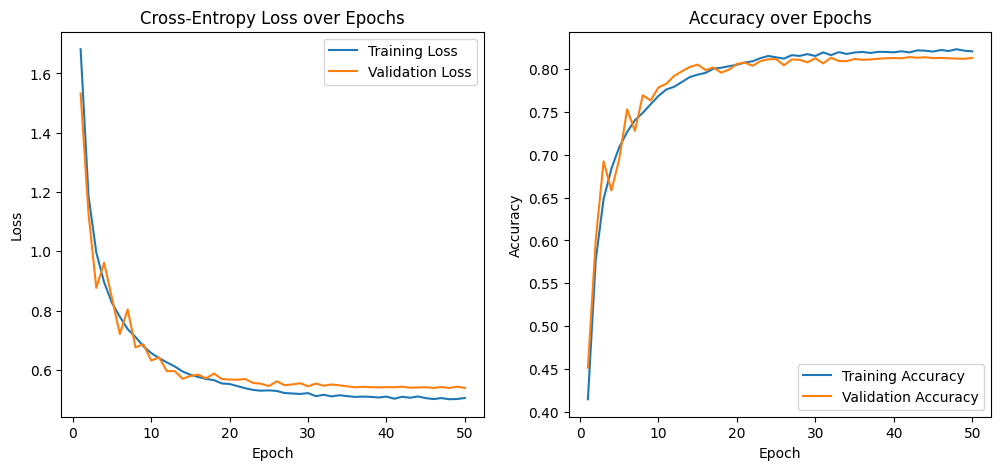

In [40]:

#Plot the cross entropy loss curve and the accuracy curve

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Cross-Entropy Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show

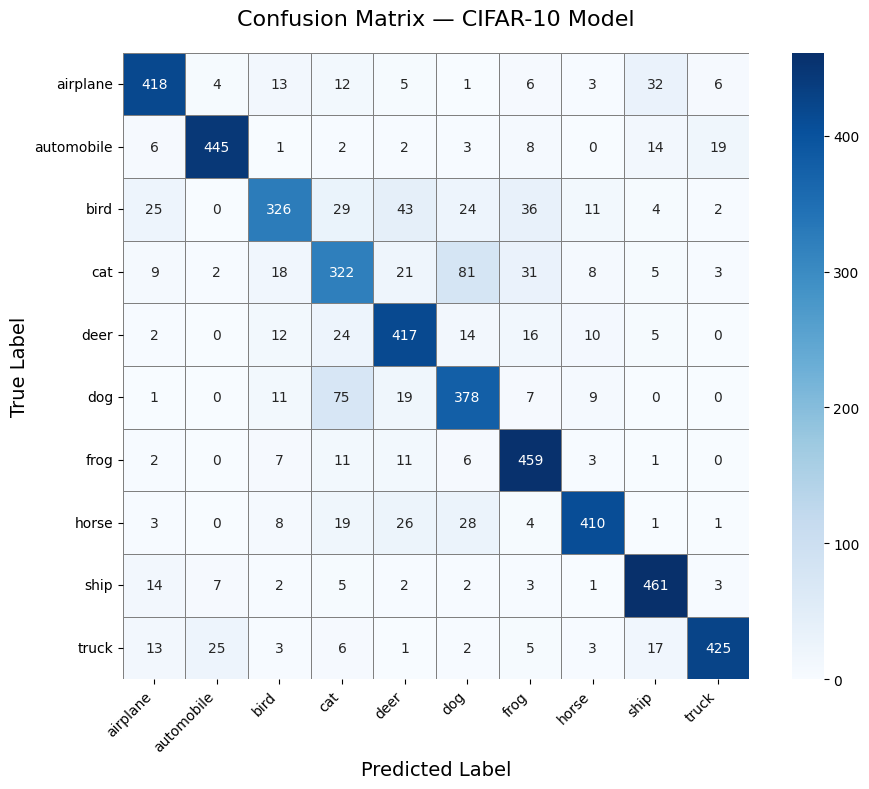

In [43]:
gt = np.argmax(y_val_cat, axis=1)
# Compute confusion matrix
cm = confusion_matrix(gt, predictions)
# CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck']
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
      xticklabels=class_names,
      yticklabels=class_names,
      cbar=True, square=True,
      linewidths=0.5, linecolor='gray')
plt.title('Confusion Matrix — CIFAR-10 Model', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Identifying the class of an image

In [17]:
#Download the image in Google Colab
from google.colab import files
uploaded = files.upload()

# Preprocessing the image to fit our model
from PIL import Image
import numpy as np
def preprocess_image_from_path(path):
    img = Image.open(path).convert('RGB')
    img = img.resize((32, 32))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array
# Predict the result
img_array = preprocess_image_from_path('bacco.jpg')
prediction = model5.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)[0]
print("Predicted class:", class_names[predicted_class_index])

Saving bacco.jpg to bacco.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted class: deer
